In [5]:
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.nn.modules.batchnorm import BatchNorm1d
import torch.nn.functional as F

In [2]:
train_data = datasets.CIFAR10(root="./cifar10_data", train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.CIFAR10(root="./cifar10_data", train=False, download=True, transform=transforms.ToTensor())

train_size = int(len(train_data) * 0.8)
val_size = len(train_data) - train_size

train_data, val_data = torch.utils.data.random_split(train_data, [train_size, val_size])

train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)

100%|██████████| 170498071/170498071 [00:02<00:00, 66454989.01it/s]


Extracting ./cifar10_data/cifar-10-python.tar.gz to ./cifar10_data
Files already downloaded and verified


In [3]:
for batch in train_loader:
  batch_images, batch_labels = batch
  break
batch_images.shape

torch.Size([64, 3, 32, 32])

In [6]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()

    self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=(3, 3), padding=1) # 32x32x12 # padding=1 добавляет с двух сторон нулевые вектора, сохраняя ихсодный размер
    self.pool1 = nn.MaxPool2d(kernel_size=(2,2)) # 16x16x12

    self.conv2 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=(3, 3), padding=1) # 16x16x24
    self.pool2 = nn.MaxPool2d(kernel_size = (2,2)) # 8x8x24

    self.conv3 = nn.Conv2d(in_channels=24, out_channels=48, kernel_size=(3,3), padding=1) # 8x8x48
    self.pool3 = nn.MaxPool2d(kernel_size=(2,2)) # 4x4x48

    self.flatten = nn.Flatten()

    self.fc1 = nn.Linear(4 * 4 * 48, 512)
    self.bn1 = BatchNorm1d(512)

    self.fc2 = nn.Linear(512, 256)
    self.bn2 = BatchNorm1d(256)

    self.fc_out = nn.Linear(256, 10)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool1(x)
    x = F.relu(self.conv2(x))
    x = self.pool2(x)
    x = F.relu(self.conv3(x))
    x = self.pool3(x)

    x = self.flatten(x)

    x = F.relu(self.fc1(x))
    x = self.bn1(x)

    x = F.relu(self.fc2(x))
    x = self.bn2(x)

    return self.fc_out(x)



In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [9]:
model = CNN().to(device)

In [10]:
from sklearn.metrics import accuracy_score


def evaluate(model, dataloader, criterion):
  y_pred_list = []
  y_true_list = []
  losses = []
  for i, batch in enumerate(dataloader):
    X_batch, y_batch = batch

    with torch.no_grad():

      y_pred = model(X_batch.to(device))

      loss = criterion(y_pred, y_batch.to(device))
      loss = loss.item()
      losses.append(loss)

      y_pred = torch.argmax(y_pred, dim=1)

    y_pred_list.extend(y_pred.cpu().numpy())
    y_true_list.extend(y_batch.numpy())
  acc = accuracy_score(y_pred_list, y_true_list)
  return acc, np.mean(losses)

In [11]:
def train(model, criterion, optimizer, n_epoch):
  data = {
      'acc_train' : [],
      'loss_train' : [],
      'acc_val' : [],
      'loss_val' : []
  }
  for epoch in tqdm(range(n_epoch)):
    for i, batch in enumerate(train_loader):
      X_batch, y_batch = batch
      y_pred = model(X_batch.to(device))
      loss = criterion(y_pred, y_batch.to(device))

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    acc_train, loss_train = evaluate(model, train_loader, criterion)
    acc_val, loss_val = evaluate(model, val_loader, criterion)

    data['acc_train'].append(acc_train)
    data['loss_train'].append(loss_train)
    data['acc_val'].append(acc_val)
    data['loss_val'].append(loss_val)
  return model, data

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

model, data = train(model, criterion, optimizer, n_epoch=10)

  0%|          | 0/10 [00:00<?, ?it/s]

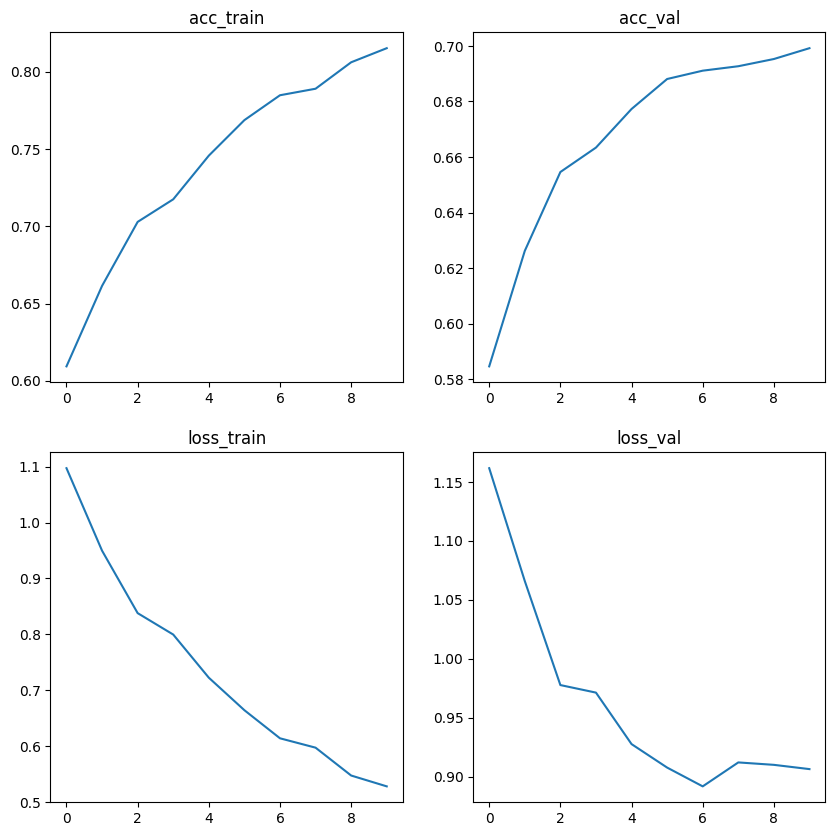

In [13]:
_, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

ox = list(range(10))

axes[0][0].plot(ox, data['acc_train'])
axes[0][0].title.set_text('acc_train')

axes[0][1].plot(ox, data['acc_val'])
axes[0][1].title.set_text('acc_val')

axes[1][0].plot(ox, data['loss_train'])
axes[1][0].title.set_text('loss_train')

axes[1][1].plot(ox, data['loss_val'])
axes[1][1].title.set_text('loss_val')

plt.show()

In [14]:
acc_val, _ = evaluate(model, test_loader, criterion)
acc_val

0.6973